In [46]:
import pandas as pd
import sys
import glob
import errno
import csv
import numpy as np
from nltk.corpus import stopwords
import re
import nltk.data
import nltk
import os
from collections import OrderedDict
from subprocess import check_call
from shutil import copyfile
from sklearn.metrics import log_loss
%matplotlib inline
import matplotlib.pyplot as plt
import mpld3
mpld3.enable_notebook()
import seaborn as sns
from collections import Counter

In [47]:
# Read data
train = "../data/train.csv"
test = "../data/test.csv"
wv = "../../../../glove.6B/glove.6B.50d.txt"
X_train = pd.read_csv( train, header=0,delimiter="," )
X_test = pd.read_csv( test, header=0,delimiter="," )
word_vecs = {}
with open(wv) as f:
    for line in f:
       vals = line.split()
       word_vecs[vals[0]] = np.array(vals[1::],dtype=float)

In [48]:
# Clean data
def getWordVectors(X_train,X_test,word_vecs):
    X_train['word_vectors'] = [ [ word_vecs[word] for word in sentence if word in word_vecs] for sentence in X_train['text']]
    X_test['word_vectors'] = [ [ word_vecs[word] for word in sentence if word in word_vecs] for sentence in X_test['text']] 
    return X_train,X_test

def getSentenceVectors(X_train,X_test):
    X_train['sentence_vectors'] =[np.mean(sentence,axis = 0) for sentence in X_train['word_vectors']]
    X_test['sentence_vectors'] =[np.mean(sentence,axis = 0) for sentence in X_test['word_vectors']] 
    return X_train,X_test

def clean(X_train,X_test):
    X_train['words'] = [re.sub("[^a-zA-Z]"," ", data).lower().split() for data in X_train['text']]
    X_test['words'] = [re.sub("[^a-zA-Z]"," ", data).lower().split() for data in X_test['text']]
    return X_train,X_test
X_train,X_test = clean(X_train,X_test)
X_train,X_test = getWordVectors(X_train,X_test,word_vecs)
X_train,X_test = getSentenceVectors(X_train,X_test)
#X_train.head()

Text(0,0.5,u'Probability')

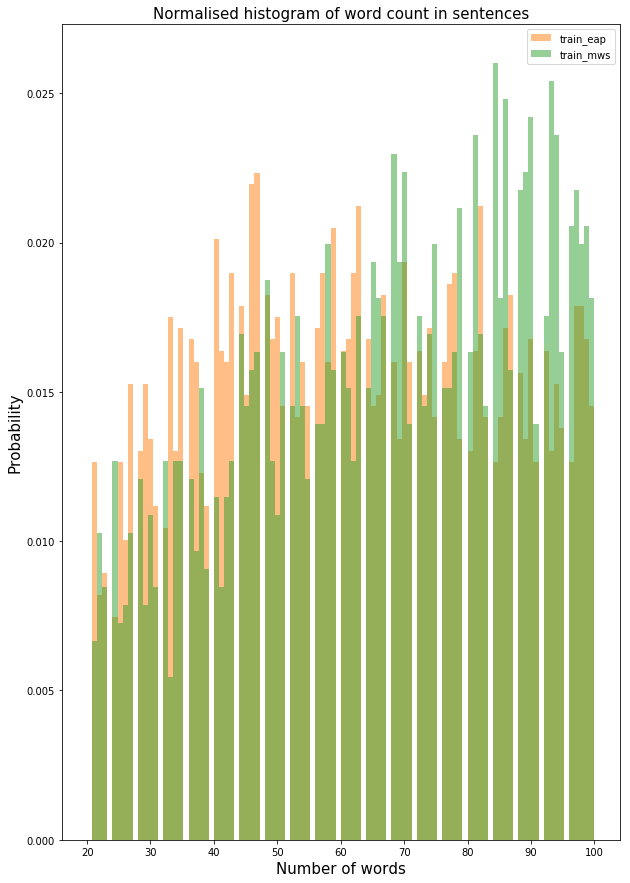

In [49]:
# Word Count
pal = sns.color_palette()

train_eap = pd.Series(X_train[X_train['author'] == 'EAP']['text'].tolist())
train_mws = pd.Series(X_train[X_train['author'] == 'MWS']['text'].tolist())
train_hpl = pd.Series(X_train[X_train['author'] == 'HPL']['text'].tolist())
dist_train_eap = train_eap.apply(len)
dist_train_mws = train_mws.apply(len)
dist_train_hpl = train_hpl.apply(len)
plt.figure(figsize=(10, 15))
plt.hist(dist_train_eap, bins=100, range=[20, 100], color=pal[1], normed=True,alpha=0.5, label='train_eap')
plt.hist(dist_train_mws, bins=100, range=[20, 100], color=pal[2], normed=True,alpha=0.5, label='train_mws')
#plt.hist(dist_train_hpl, bins=100, range=[20, 100], color=pal[3], normed=True,alpha=0.5, label='train_hpl')
plt.title('Normalised histogram of word count in sentences', fontsize=15)
plt.legend()
plt.xlabel('Number of words', fontsize=15)
plt.ylabel('Probability', fontsize=15)

# print('mean-train {:.2f} std-train {:.2f} mean-test {:.2f} std-test {:.2f} max-train {:.2f} max-test {:.2f}'.format(dist_train.mean(), 
#                           dist_train.std(), dist_test.mean(), dist_test.std(), dist_train.max(), dist_test.max()))

In [50]:
# Stop word analysis
from nltk.corpus import stopwords

dist_train_eap = [y for x in X_train[X_train['author'] == 'EAP']['words'] for y in x]
sw_dist_train_eap = [word for word in dist_train_eap if word in stopwords.words('english')]
print('Sentences with stop words for EAP: {:.2f}%'.format(len(sw_dist_train_eap)* 100/len(dist_train_eap) ))

dist_train_mws = [y for x in X_train[X_train['author'] == 'MWS']['words'] for y in x]
sw_dist_train_mws = [word for word in dist_train_mws if word in stopwords.words('english')]
print('Sentences with stop words for MWS: {:.2f}%'.format(len(sw_dist_train_mws)* 100/len(dist_train_mws) ))

dist_train_hpl = [y for x in X_train[X_train['author'] == 'HPL']['words'] for y in x]
sw_dist_train_hpl = [word for word in dist_train_hpl if word in stopwords.words('english')]
print('Sentences with stop words for HPL: {:.2f}%'.format(len(sw_dist_train_hpl)* 100/len(dist_train_hpl) ))
#

Sentences with stop words for EAP: 52.00%
Sentences with stop words for MWS: 52.00%
Sentences with stop words for HPL: 48.00%


In [52]:
# Punctuation analysis
import re
punctuation = "[:;]"
_train_eap = [y for x in X_train[X_train['author'] == 'EAP']['text'] for y in x.split()]
_p_train_eap = [word for word in _train_eap if bool(re.search(punctuation, word))]
print('Sentences with punctuation for EAP: {:.10f}%'.format(len(_p_train_eap)* 100.0/len(_train_eap) ))

_train_mws = [y for x in X_train[X_train['author'] == 'MWS']['text'] for y in x.split()]
_p_train_mws = [word for word in _train_mws if bool(re.search(punctuation, word))]
print('Sentences with punctuation for MWS: {:.10f}%'.format(len(_p_train_mws)* 100.0/len(_train_mws) ))

_train_hpl = [y for x in X_train[X_train['author'] == 'HPL']['text'] for y in x.split()]
_p_train_hpl = [word for word in _train_hpl if bool(re.search(punctuation, word))]
print('Sentences with punctuation for HPL: {:.10f}%'.format(len(_p_train_hpl)* 100.0/len(_train_hpl) ))

Sentences with punctuation for EAP: 0.7607154407%
Sentences with punctuation for MWS: 1.8109951119%
Sentences with punctuation for HPL: 0.7596504331%


In [53]:
dist_train_eap = [y for x in X_train[X_train['author'] == 'EAP']['words'] for y in x]
nsw_dist_train_eap = [word for word in dist_train_eap if word not in stopwords.words('english')]
c = Counter(nsw_dist_train_eap)
#print [ (i, c[i]*100.0  / len(nsw_dist_train_eap))  for i in c]

dist_train_mws = [y for x in X_train[X_train['author'] == 'MWS']['words'] for y in x]
nsw_dist_train_mws = [word for word in dist_train_mws if word not in stopwords.words('english')]
c = Counter(nsw_dist_train_mws)
#print [ (i, c[i]*100.0  / len(nsw_dist_train_mws))  for i in c]

dist_train_hpl = [y for x in X_train[X_train['author'] == 'HPL']['words'] for y in x]
nsw_dist_train_hpl = [word for word in dist_train_hpl if word not in stopwords.words('english')]
c = Counter(nsw_dist_train_hpl)
#print [ (i, c[i]*100.0  / len(nsw_dist_train_hpl))  for i in c]

In [54]:
# weighted word  count percentage for whole document


# If a word appears only once, we ignore it completely (likely a typo)
# Epsilon defines a smoothing constant, which makes the effect of extremely rare words smaller
def get_weight(count, eps=10000, min_count=2):
    if count < min_count:
        return 0
    else:
        return 1.0 / (count + eps)

eps = 5000 
dist_train = [y for x in X_train['text'] for y in x]
words = dist_train
counts = Counter(words)
weights = {word: get_weight(count) for word, count in counts.items()}

# print('Most common words and weights:')
# print(sorted(weights.items(), key=lambda x: x[1] if x[1] > 0 else 9999)[:10])
# print('\nLeast common words and weights: ')
# print (sorted(weights.items(), key=lambda x: x[1], reverse=True)[:10])

In [55]:
# weighted word count percentage for each class

# If a word appears only once, we ignore it completely (likely a typo)
# Epsilon defines a smoothing constant, which makes the effect of extremely rare words smaller
def get_weight(count, eps=10000, min_count=2):
    if count < min_count:
        return 0
    else:
        return 1.0 / (count + eps)

#EAP
eps = 5000 
words = dist_train_eap
counts = Counter(words)
weights = {word: get_weight(count) for word, count in counts.items()}

print ('EAP :\n')
print('Most common words and weights:')
print(sorted(weights.items(), key=lambda x: x[1] if x[1] > 0 else 9999)[:10])
print('\nLeast common words and weights: ')
print (sorted(weights.items(), key=lambda x: x[1], reverse=True)[:10])

#MWS
eps = 5000 
words = dist_train_mws
counts = Counter(words)
weights = {word: get_weight(count) for word, count in counts.items()}

print ('\nMWS :\n')
print('Most common words and weights:')
print(sorted(weights.items(), key=lambda x: x[1] if x[1] > 0 else 9999)[:10])
print('\nLeast common words and weights: ')
print (sorted(weights.items(), key=lambda x: x[1], reverse=True)[:10])

#HPL
eps = 5000 
words = dist_train_hpl
counts = Counter(words)
weights = {word: get_weight(count) for word, count in counts.items()}

print ('\nHPL :\n')
print('Most common words and weights:')
print(sorted(weights.items(), key=lambda x: x[1] if x[1] > 0 else 9999)[:10])
print('\nLeast common words and weights: ')
print (sorted(weights.items(), key=lambda x: x[1], reverse=True)[:10])

EAP :

Most common words and weights:
[('the', 4.0011203136878324e-05), ('of', 5.2709255745308875e-05), ('and', 6.355258976803305e-05), ('to', 6.772773450728073e-05), ('a', 6.788405403570701e-05), ('in', 7.080147267063155e-05), ('i', 7.252157516861267e-05), ('that', 8.108327252087895e-05), ('it', 8.10898475510866e-05), ('was', 8.18062827225131e-05)]

Least common words and weights: 
[('ringlets', 9.998000399920016e-05), ('vassals', 9.998000399920016e-05), ('formless', 9.998000399920016e-05), ('originality', 9.998000399920016e-05), ('dvelf', 9.998000399920016e-05), ('bossuet', 9.998000399920016e-05), ('trodden', 9.998000399920016e-05), ('dangled', 9.998000399920016e-05), ('rafaelle', 9.998000399920016e-05), ('perforations', 9.998000399920016e-05)]

MWS :

Most common words and weights:
[('the', 5.0867287247571086e-05), ('of', 6.196938712276135e-05), ('and', 6.202319667555666e-05), ('to', 6.743543057522422e-05), ('i', 6.985191394244202e-05), ('a', 7.866582756450598e-05), ('my', 7.8995181

In [56]:
counts['upon']

186

In [57]:
# Feature Engineering
# Punctuation perc,Stop word perc, tfidf sum per sentence


In [58]:
# Feature Engineering

# Punctuation

punctuation = "[;:]"
_train =  [ sentence.split() for sentence in X_train['text'] ]
_p_train = [[word for word in sentence if bool(re.search(punctuation, word))] for sentence in _train]
X_train['punc_;:'] = [len([word for word in sentence if bool(re.search(punctuation, word))])*100.0/len(sentence) for sentence in _train]    


punctuation = "[,.]"
_train =  [ sentence.split() for sentence in X_train['text'] ]
_p_train = [[word for word in sentence if bool(re.search(punctuation, word))] for sentence in _train]
X_train['punc_,'] = [len([word for word in sentence if bool(re.search(punctuation, word))])*100.0/len(sentence) for sentence in _train]    


punctuation = "[?]"
_train =  [ sentence.split() for sentence in X_train['text'] ]
_p_train = [[word for word in sentence if bool(re.search(punctuation, word))] for sentence in _train]
X_train['punc_?'] = [len([word for word in sentence if bool(re.search(punctuation, word))])*100.0/len(sentence) for sentence in _train]    


punctuation = "[\']"
_train =  [ sentence.split() for sentence in X_train['text'] ]
_p_train = [[word for word in sentence if bool(re.search(punctuation, word))] for sentence in _train]
X_train['punc_\''] = [len([word for word in sentence if bool(re.search(punctuation, word))])*100.0/len(sentence) for sentence in _train]    

punctuation = "[\"]"
_train =  [ sentence.split() for sentence in X_train['text'] ]
_p_train = [[word for word in sentence if bool(re.search(punctuation, word))] for sentence in _train]
X_train['punc_\"'] = [len([word for word in sentence if bool(re.search(punctuation, word))])*100.0/len(sentence) for sentence in _train]    





punctuation = "[;:]"
_test =  [ sentence.split() for sentence in X_test['text'] ]
_p_test = [[word for word in sentence if bool(re.search(punctuation, word))] for sentence in _test]
X_test['punc_;:'] = [len([word for word in sentence if bool(re.search(punctuation, word))])*100.0/len(sentence) for sentence in _test]    


punctuation = "[,.]"
_test =  [ sentence.split() for sentence in X_test['text'] ]
_p_test = [[word for word in sentence if bool(re.search(punctuation, word))] for sentence in _test]
X_test['punc_,'] = [len([word for word in sentence if bool(re.search(punctuation, word))])*100.0/len(sentence) for sentence in _test]    


punctuation = "[?]"
_test =  [ sentence.split() for sentence in X_test['text'] ]
_p_test= [[word for word in sentence if bool(re.search(punctuation, word))] for sentence in _test]
X_test['punc_?'] = [len([word for word in sentence if bool(re.search(punctuation, word))])*100.0/len(sentence) for sentence in _test]    


punctuation = "[\']"
_test =  [ sentence.split() for sentence in X_test['text'] ]
_p_test = [[word for word in sentence if bool(re.search(punctuation, word))] for sentence in _test]
X_test['punc_\''] = [len([word for word in sentence if bool(re.search(punctuation, word))])*100.0/len(sentence) for sentence in _test]    

punctuation = "[\"]"
_test =  [ sentence.split() for sentence in X_test['text'] ]
_p_test = [[word for word in sentence if bool(re.search(punctuation, word))] for sentence in _test]
X_test['punc_\"'] = [len([word for word in sentence if bool(re.search(punctuation, word))])*100.0/len(sentence) for sentence in _test]    


In [60]:
# Feature Engineering

# Stop word perc
from nltk.corpus import stopwords

_dist_train = [x for x in X_train['words']]
X_train['stop_word'] = [len([word for word in sentence if word in stopwords.words('english')])*100.0/len(sentence) for sentence in _dist_train]

_dist_test = [x for x in X_test['words']]
X_test['stop_word'] = [len([word for word in sentence if word in stopwords.words('english')])*100.0/len(sentence) for sentence in _dist_test]    

In [63]:
# Feature Engineering

# tfidf sum per sentence
import numpy as np
from nltk.corpus import stopwords

_dist_train = [x for x in X_train['words']]
X_train['tfidf'] = ([np.mean([weights[word] for word in sentence if word in weights]) for sentence in _dist_train]) 

_dist_test = [x for x in X_test['words']]
X_test['tfidf'] = ([np.mean([weights[word] for word in sentence if word in weights]) for sentence in _dist_test]) 

,id,text,author,word_vectors,sentence_vectors
0,id26305,"[this, process, however, afforded, me, no, mea...",EAP,"[[0.53074, 0.40117, -0.40785, 0.15444, 0.47782...","[0.358360097561, 0.0879906829268, -0.143758756..."
1,id17569,"[it, never, once, occurred, to, me, that, the,...",HPL,"[[0.61183, -0.22072, -0.10898, -0.052967, 0.50...","[0.428678857143, -0.0737922928571, -0.00208892..."
2,id11008,"[in, his, left, hand, was, a, gold, snuff, box...",EAP,"[[0.33042, 0.24995, -0.60874, 0.10923, 0.03637...","[0.187373827714, 0.104112057143, -0.1598536857..."
3,id27763,"[how, lovely, is, spring, as, we, looked, from...",MWS,"[[0.68938, -0.10644, 0.17083, -0.37583, 0.7517...","[0.257801382353, 0.285311176471, -0.2542245029..."
4,id12958,"[finding, nothing, else, not, even, gold, the,...",HPL,"[[1.0427, -0.0063726, 0.14249, -0.20253, 0.819...","[0.101528666667, 0.121712837037, -0.1127860222..."
5,id22965,"[a, youth, passed, in, solitude, my, best, yea...",MWS,"[[0.21705, 0.46515, -0.46757, 0.10082, 1.0135,...","[0.309799130488, 0.126082134146, -0.1952628902..."
6,id09674,"[the, astronomer, perhaps, at, this, point, to...",EAP,"[[0.418, 0.24968, -0.41242, 0.1217, 0.34527, -...","[0.306266333333, 0.323390571429, -0.1377132857..."
7,id13515,"[the, surcingle, hung, in, ribands, from, my, ...",EAP,"[[0.418, 0.24968, -0.41242, 0.1217, 0.34527, -...","[0.143111666667, 0.259786166667, -0.2371526666..."
8,id19322,"[i, knew, that, you, could, not, say, to, your...",EAP,"[[0.11891, 0.15255, -0.082073, -0.74144, 0.759...","[0.426775595349, 0.0796656348837, -0.073560820..."
9,id00912,"[i, confess, that, neither, the, structure, of...",MWS,"[[0.11891, 0.15255, -0.082073, -0.74144, 0.759...","[0.337920434783, 0.182588347826, -0.2406443695..."


NameError: name 'y_train' is not defined

In [108]:
from sklearn.preprocessing import LabelEncoder
import xgboost as xgb
def do(X_train,X_test):
    columns = ['punc_;:','punc_,','punc_?','punc_\'','punc_\"','stop_word']
    x_train = X_train[columns]
    x_test = X_test[columns]
    y_train = X_train['author']

    # Set our parameters for xgboost
    params = {}
    params['objective'] = 'multi:softprob'
    params['eval_metric'] = 'mlogloss'
    params['num_class'] = 3
    params['eta'] = 0.02
    params['max_depth'] = 5
    params['verbost_eval'] = 10
    #split some of the data off for validation
    from sklearn.cross_validation import train_test_split
    x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=0.2, random_state=4242)

    #Train xgb
    d_train = xgb.DMatrix(x_train, label=LabelEncoder().fit_transform(y_train))
    d_valid = xgb.DMatrix(x_valid, label=LabelEncoder().fit_transform(y_valid) )

    watchlist = [(d_train, 'train'), (d_valid, 'valid')]

    bst = xgb.train(params, d_train, 400, watchlist, early_stopping_rounds=50,verbose_eval=10)

    d_test = xgb.DMatrix(x_test)
    p_test = bst.predict(d_test)
    return p_test
result = do(X_train,X_test)

[0]	train-mlogloss:1.09493	valid-mlogloss:1.0952
Multiple eval metrics have been passed: 'valid-mlogloss' will be used for early stopping.

Will train until valid-mlogloss hasn't improved in 50 rounds.
[10]	train-mlogloss:1.06335	valid-mlogloss:1.06615
[20]	train-mlogloss:1.03939	valid-mlogloss:1.04468
[30]	train-mlogloss:1.02092	valid-mlogloss:1.02842
[40]	train-mlogloss:1.00634	valid-mlogloss:1.01577
[50]	train-mlogloss:0.994788	valid-mlogloss:1.00625
[60]	train-mlogloss:0.985387	valid-mlogloss:0.998894
[70]	train-mlogloss:0.977752	valid-mlogloss:0.993208
[80]	train-mlogloss:0.971411	valid-mlogloss:0.988598
[90]	train-mlogloss:0.966023	valid-mlogloss:0.984947
[100]	train-mlogloss:0.96142	valid-mlogloss:0.982004
[110]	train-mlogloss:0.957392	valid-mlogloss:0.979735
[120]	train-mlogloss:0.953909	valid-mlogloss:0.97788
[130]	train-mlogloss:0.950802	valid-mlogloss:0.976389
[140]	train-mlogloss:0.948152	valid-mlogloss:0.97512
[150]	train-mlogloss:0.945711	valid-mlogloss:0.974075
[160]	tra

In [109]:
# Get Loss of result

def getLoss(result,X_train):
    eap = log_loss(np.array(pd.get_dummies(X_train['author'])['EAP']), np.array(result['EAP']))
    mws = log_loss(np.array(pd.get_dummies(X_train['author'])['MWS']), np.array(result['MWS']))
    hpl = log_loss(np.array(pd.get_dummies(X_train['author'])['HPL']), np.array(result['HPL']))
    return 'EAP:',eap,'MWS:',mws,'HPL:',hpl 
getLoss(result,X_train)


IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [110]:
# Write Results

def writeResult(result,test):
    # count number of files
    path, dirs, files = os.walk("../results").next()
    file_count = len(files)/2+1

    # Write the test results
    data=OrderedDict()
    data["id"]=test["id"] 
    data["EAP"]=result[0]#["EAP"]
    data["HPL"]=result[1]#["HPL"]	
    data["MWS"]=result[2]#["MWS"]
    output = pd.DataFrame(data=data)
    filename = "../results/result"+str(file_count)+".csv"
    output.to_csv( filename, index=False )
    filename = "../results/result"+str(file_count)+"compr.csv"
    output.to_csv( filename, index=False )
    check_call(['gzip', filename])

writeResult(result.T,X_test)

array([ 0.55876172,  0.2927255 ,  0.32451135, ...,  0.26621005,
        0.29423982,  0.30873859], dtype=float32)